In [1]:
from waveletvar import *
import ccxt
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

In [2]:
exchange = ccxt.binance()
btc_symbol = 'BTC/USDT'
sol_symbol = 'SOL/USDT'
end_date = datetime.now()
start_date = end_date - timedelta(days=720)


btc_ohlcv = exchange.fetch_ohlcv(btc_symbol, timeframe='1d', since=int(start_date.timestamp() * 1000), limit=720)
btc_df = pd.DataFrame(btc_ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
btc_df['timestamp'] = pd.to_datetime(btc_df['timestamp'], unit='ms', utc=True)  # Ensure UTC
btc_df.set_index('timestamp', inplace=True)

sol_ohlcv = exchange.fetch_ohlcv(sol_symbol, timeframe='1d', since=int(start_date.timestamp() * 1000), limit=720)
sol_df = pd.DataFrame(sol_ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
sol_df['timestamp'] = pd.to_datetime(sol_df['timestamp'], unit='ms', utc=True)  # Ensure UTC
sol_df.set_index('timestamp', inplace=True)




In [3]:

btc_data_log = np.log(btc_df[['close']].rename(columns={'close': 'BTC'}))
sol_data_log = np.log(sol_df[['close']].rename(columns={'close': 'sol'}))

combined_data = pd.merge(btc_data_log, sol_data_log, left_index=True, right_index=True, how='inner')

# Convert to NumPy arrays
btc_logr = np.diff(combined_data['BTC'].to_numpy())
sol_logr = np.diff(combined_data['sol'].to_numpy())


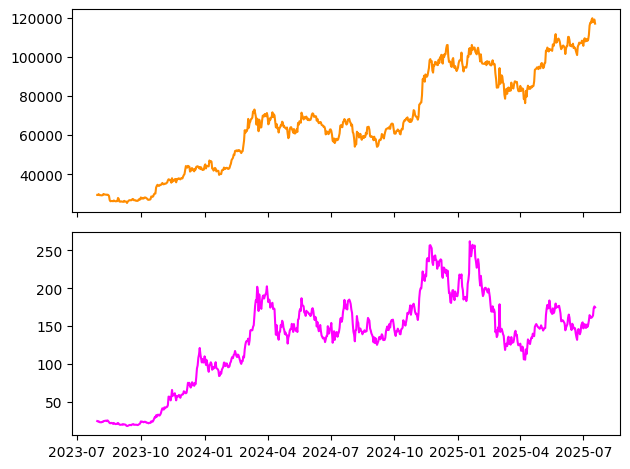

In [4]:
fig, ax = plt.subplots(2, 1, sharex=True)
ax[0].plot(btc_df["close"],  color='darkorange')
ax[1].plot(sol_df["close"], color='magenta')

plt.tight_layout()  # Optional: improves spacing between plots
plt.show()


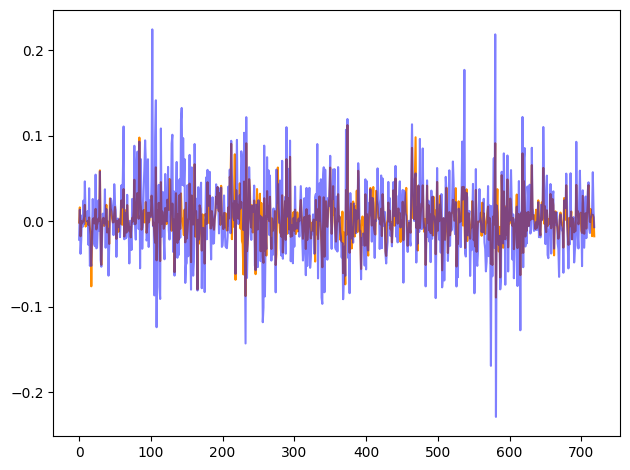

In [5]:
figur = plt.figure()

plt.plot(btc_logr, color="darkorange", alpha = 1)
plt.plot(sol_logr, color="blue", alpha = 0.5)
plt.tight_layout()
plt.show()



In [15]:
wavelet_correlation_CI(btc_logr, sol_logr, "db6", 1, 0, 0.05)

[0.6301328039787703, 0.6725873681155945, 0.7110326895980408]

In [24]:
lags = [i for i in range(-100, 101)]
levels = [i for i in range(1,7)]
P1, P2 = np.meshgrid(levels, lags)
Z = np.array([[wavelet_correlation(btc_logr, sol_logr, "db6", P1, P2) for P1 in levels] for P2 in lags])

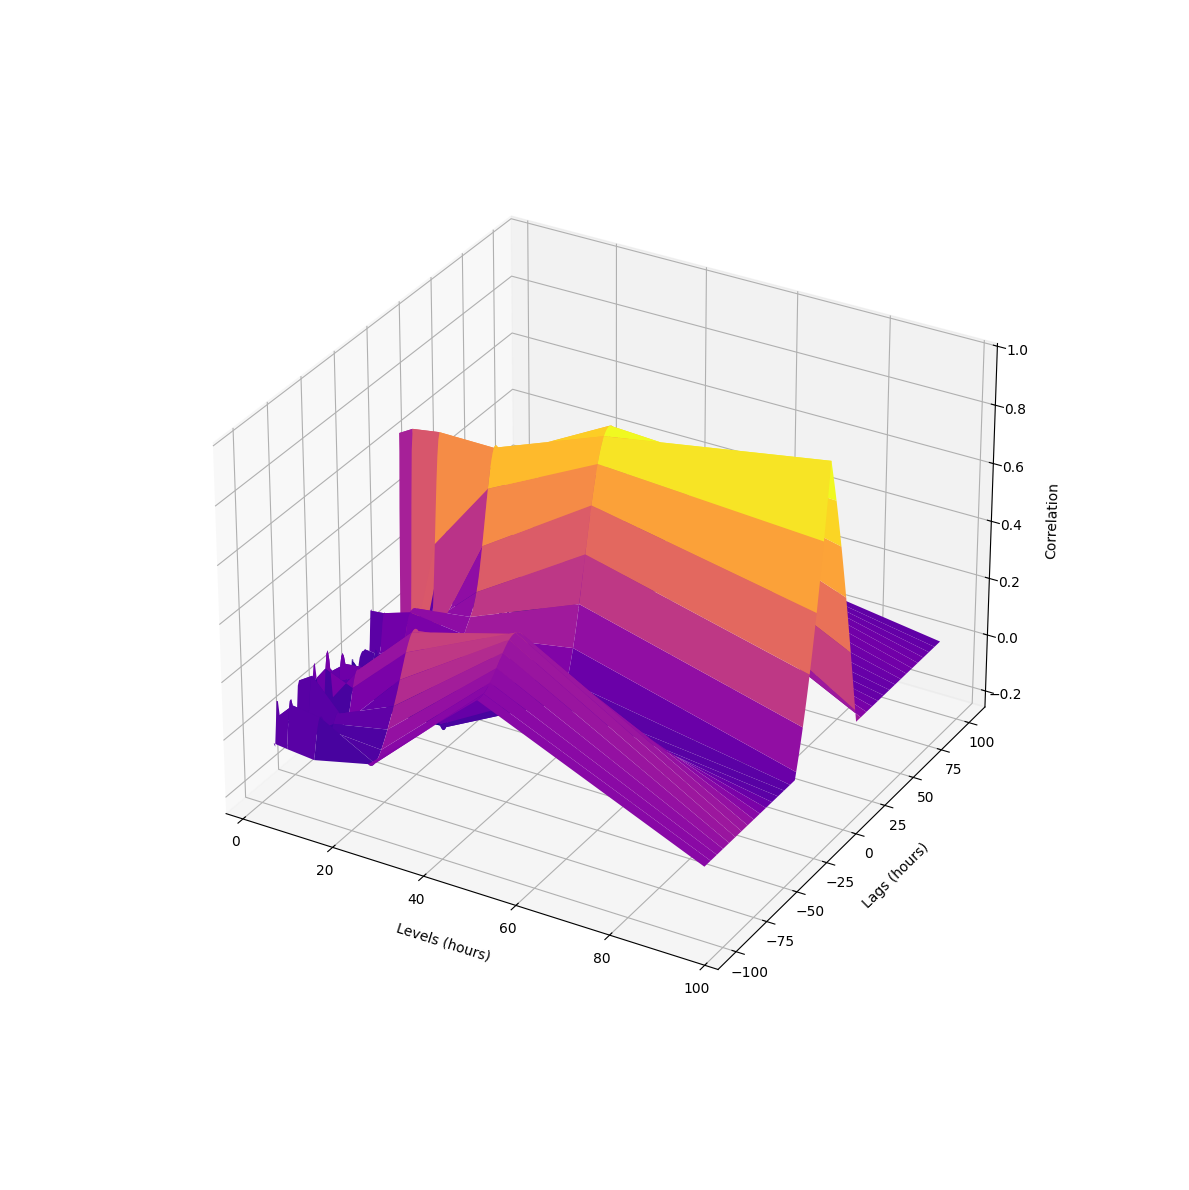

In [30]:
fig = plt.figure(figsize=(20, 12))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(1.5*2**(P1), P2, Z, cmap='plasma')
ax.set_xlabel('Levels (hours)', labelpad=15)
ax.set_ylabel('Lags (hours)', labelpad=15)
ax.set_zlabel('Correlation',labelpad=15)
ax.set_box_aspect(None, zoom=0.75) 
plt.tight_layout()
plt.show()

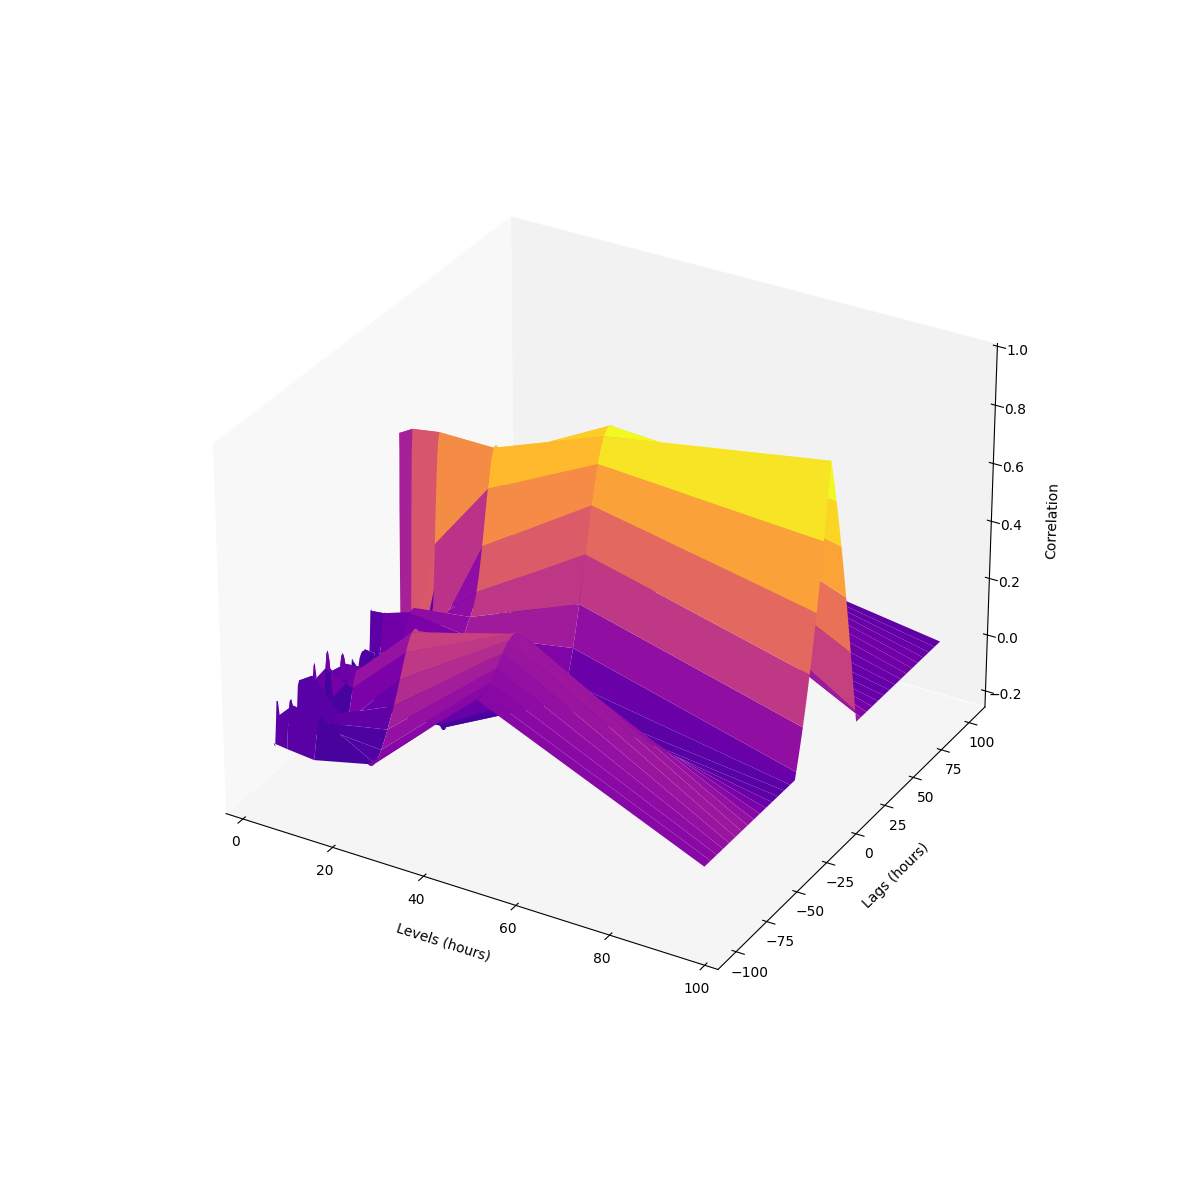

In [35]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20, 12))
ax = fig.add_subplot(111, projection='3d')

# Plot
surf = ax.plot_surface(1.5 * 2**(P1), P2, Z, cmap='plasma', edgecolor='none')

# Labels
ax.set_xlabel('Levels (hours)', labelpad=15)
ax.set_ylabel('Lags (hours)', labelpad=15)
ax.set_zlabel('Correlation', labelpad=15)

# Cleaner white background
ax.set_facecolor('white')
fig.patch.set_facecolor('white')
ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor('w')

# Remove gridlines and spines
ax.grid(False)
ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)

# Adjust aspect ratio
ax.set_box_aspect(None, zoom=0.75)

plt.tight_layout()
plt.show()
